In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
import utils
import models
from torchsummary import summary
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau

Files already downloaded and verified
Files already downloaded and verified


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

inttoclasses = {i:classes for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
#Mean Train
print(utils.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(utils.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(utils.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(utils.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [5]:
training_iterator = iter(utils.train_loader)

In [6]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

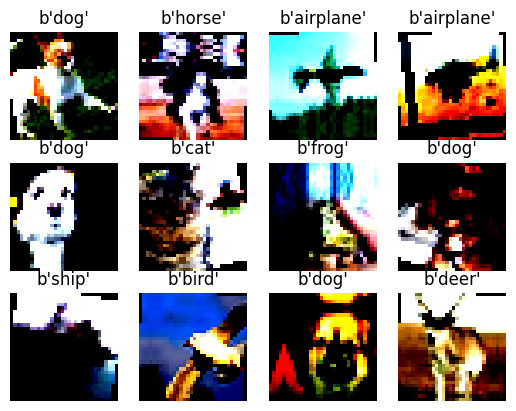

In [7]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [8]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [9]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss


In [10]:
device

'mps'

In [11]:
model = models.model_groupnorm().to(device= device)

In [12]:


optimizer = optim.SGD(params = model.parameters(), lr = 0.1, momentum= 0.9)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
# New Line
num_epochs = 20

   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, utils.train_loader, optimizer)
    test_loss = test(model, device, utils.test_loader)
    scheduler.step(test_loss)


Epoch 1


Loss=1.799043893814087 Batch_id=390 Accuracy=28.00: 100%|██████████| 391/391 [00:25<00:00, 15.29it/s] 



Test set: Average loss: 1.6502, Accuracy: 3955/10000 (39.55%)

Epoch 2


Loss=1.6601837873458862 Batch_id=390 Accuracy=38.57: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 1.5118, Accuracy: 4545/10000 (45.45%)

Epoch 3


Loss=1.3393030166625977 Batch_id=390 Accuracy=45.41: 100%|██████████| 391/391 [00:24<00:00, 15.78it/s]



Test set: Average loss: 1.4125, Accuracy: 4869/10000 (48.69%)

Epoch 4


Loss=1.296502947807312 Batch_id=390 Accuracy=50.47: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s] 



Test set: Average loss: 1.1756, Accuracy: 5729/10000 (57.29%)

Epoch 5


Loss=1.4050501585006714 Batch_id=390 Accuracy=53.97: 100%|██████████| 391/391 [00:24<00:00, 15.80it/s]



Test set: Average loss: 1.1600, Accuracy: 5846/10000 (58.46%)

Epoch 6


Loss=1.008621335029602 Batch_id=390 Accuracy=57.00: 100%|██████████| 391/391 [00:25<00:00, 15.50it/s] 



Test set: Average loss: 1.0243, Accuracy: 6331/10000 (63.31%)

Epoch 7


Loss=0.9931807518005371 Batch_id=390 Accuracy=59.51: 100%|██████████| 391/391 [00:24<00:00, 15.73it/s]



Test set: Average loss: 0.9786, Accuracy: 6472/10000 (64.72%)

Epoch 8


Loss=1.149795413017273 Batch_id=390 Accuracy=61.33: 100%|██████████| 391/391 [00:25<00:00, 15.60it/s] 



Test set: Average loss: 1.0142, Accuracy: 6412/10000 (64.12%)

Epoch 9


Loss=1.033018708229065 Batch_id=390 Accuracy=63.06: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s] 



Test set: Average loss: 0.9409, Accuracy: 6652/10000 (66.52%)

Epoch 10


Loss=1.035856008529663 Batch_id=390 Accuracy=64.20: 100%|██████████| 391/391 [00:24<00:00, 15.78it/s] 



Test set: Average loss: 0.9234, Accuracy: 6777/10000 (67.77%)

Epoch 11


Loss=0.8815121054649353 Batch_id=390 Accuracy=65.57: 100%|██████████| 391/391 [00:25<00:00, 15.40it/s]



Test set: Average loss: 0.8484, Accuracy: 6963/10000 (69.63%)

Epoch 12


Loss=0.9753175973892212 Batch_id=390 Accuracy=66.43: 100%|██████████| 391/391 [00:24<00:00, 15.64it/s]



Test set: Average loss: 0.8376, Accuracy: 7068/10000 (70.68%)

Epoch 13


Loss=0.8245981335639954 Batch_id=390 Accuracy=67.59: 100%|██████████| 391/391 [00:24<00:00, 15.79it/s]



Test set: Average loss: 0.7904, Accuracy: 7193/10000 (71.93%)

Epoch 14


Loss=0.6918045878410339 Batch_id=390 Accuracy=67.83: 100%|██████████| 391/391 [00:25<00:00, 15.32it/s]



Test set: Average loss: 0.7717, Accuracy: 7313/10000 (73.13%)

Epoch 15


Loss=0.7351058721542358 Batch_id=390 Accuracy=68.75: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]



Test set: Average loss: 0.8346, Accuracy: 7187/10000 (71.87%)

Epoch 16


Loss=0.6307867765426636 Batch_id=390 Accuracy=69.53: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]



Test set: Average loss: 0.7973, Accuracy: 7196/10000 (71.96%)

Epoch 17


Loss=0.6993802785873413 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [00:24<00:00, 15.92it/s]



Test set: Average loss: 0.7274, Accuracy: 7490/10000 (74.90%)

Epoch 18


Loss=0.7371540069580078 Batch_id=390 Accuracy=70.87: 100%|██████████| 391/391 [00:24<00:00, 15.90it/s]



Test set: Average loss: 0.7401, Accuracy: 7447/10000 (74.47%)

Epoch 19


Loss=1.114714503288269 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s] 



Test set: Average loss: 0.7027, Accuracy: 7567/10000 (75.67%)

Epoch 20


Loss=0.8921698927879333 Batch_id=390 Accuracy=71.72: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 0.7086, Accuracy: 7553/10000 (75.53%)



In [13]:
model = models.model_groupnorm()
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         GroupNorm-3           [-1, 32, 32, 32]              64
         Dropout2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,248
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
         Dropout2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             528
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,640
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
        Dropout2d-14           [-1, 32,